<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

$\newcommand\innerprod[2]{\langle #1, #2 \rangle}$
$\newcommand\vect[1]{\mathbf #1}$
$\newcommand{\mR}{\vect{R}}$
$\newcommand{\vf}{\vect{f}}$
$\newcommand{\vg}{\vect{g}}$
$\newcommand\Tex{}$
$\newcommand\norm[2][\Tnorm]{{\left\|#2\right\|}_{#1}}$
$\newcommand\PR[1]{\mathrm{P}\left[#1\right]}$
$\newcommand{\reals}{\mathbb R}$

# Overlapping co-CLuster Recommendation algorithm (OCuLaR)


This notebook explains how the `OCuLaR` algorithm is working and how it can be implemented. It then shows how to prepare a real-world data set to be fed to the algorithm. Last, but not least, we evaluate the performance of `OCuLaR` by computing the recall.

Some familiarity with Python is recommended. This notebook runs on Python.

## Table of contents


**Part A: [The algorithm](#Part-A:-The-algorithm)**
  1. [Introduction](#1.-Introduction)<br>
  2. [Illustrative example](#2.-Illustrative-example)<br>
  3. [Generative model](#3.-Generative-model)<br>
  4. [Fitting the model parameters](#4.-Fitting-the-model-parameters)<br>
    4.1 [Computing the $L$ and $Q$](#4.1-Computing-the-$L$-and-$Q$)<br>
  5. [Implementation and complexity](#5.-Implementation-and-complexity)<br>
    5.1 [Alternative: Vectorized DQfi/DQfu](#5.1-Alternative:-vectorized-DQfi/DQfu)<br>
    5.2 [Unit tests](#5.2-Unit-tests)<br>
  6. [Ocular fit on the example](#6.-Ocular-fit-on-the-example)
  
  
  
**Part B: [Ocular with MovieLens](#Part-B:-Ocular-with-MovieLens)**
  1. [Load the MovieLens data](#1.-Load-the-MovieLens-data)<br>
    1.1 [Download the data](#1.1-Download-the-data)<br>
    1.2 [Load the data file to the notebook](#1.2-Load-the-data-file-to-the-notebook)<br>
  2. [Prepare the data](#2.-Prepare-the-data)<br>
    2.1 [Select positive ratings](#2.1-Select-positive-ratings)<br>
    2.2 [Remove "bad" users and items](#2.2-Remove-%22bad%22-users-and-items)<br>
    2.3 [Split data](#2.3-Split-data)<br>
    2.4 [Get list of active users/items](#2.4-Get-list-of-active-users/items)<br>
    2.5 [Get user/item history](#2.5-Get-user/item-history)<br>
  3. [The selection of the step size](#3.-The-selection-of-the-step-size)<br>
  4. [Recall](#4.-Recall)<br>
  5. [Summary](#5.-Summary)

## Part A: The algorithm

In this first, part we describe the algorithm and a basic implementation of it.

References:
1. Reinhard Heckel, Vasileios Vasileiadis, Michail Vlachos. Method and system for identifying dependent components, US9524468. <a href= "https://patents.google.com/patent/US9524468B2/en" target="_blank" rel="noopener noreferrer">[link]</a>
2. Reinhard Heckel, Michail Vlachos, Thomas Parnell, Celestine Duenner. Scalable and Interpretable Product Recommendations via Overlapping Co-Clustering, IEEE 33rd International Conference on Data Engineering (ICDE), 2017, pp. 1033-1044. <a href= "http://ieeexplore.ieee.org/document/7930045/" target="_blank" rel="noopener noreferrer">[link]</a>
3. Michail Vlachos, Vassilios G. Vassiliadis, Reinhard Heckel, Abdel Labbi. Toward interpretable predictive models in B2B recommender systems. IBM Journal of Research and Development (60), 2017, pp. 11:1-11:12. <a href= "http://ieeexplore.ieee.org/document/7580713/" target="_blank" rel="noopener noreferrer">[link]</a>

## 1. Introduction
We assume that we are given a matrix $\mR$ where the rows correspond, e.g., to users or clients and the columns to items or products. 
If the $(u,i)$th element of $\mR$ takes on the value $r_{ui} =1$ this indicates that user $u$ has purchased item $i$ in the past or, more generally, that user $u$ is interested in item $i$. 
We consider all values $r_{ui}$ that are not positive ($r_{ui} =1$) as unknown ($r_{ui}=0$) because they indicate that user $u$ might be interested in $i$ or not. 
Our goal is to identify those items a user $u$ is likely to be interested in.
Put differently, we want to find the positives among the unknowns, given only positive examples.

We assume an underlying model whose parameters are factors associated with the users and items. Those factors are learned, such that the fitted model explains well the given positive examples $r_{ui}=1$.

## 2. Illustrative example
In the next figure, we provide an example of overlapping co-clusters. A dark square describes a product bought by the user in the past. One can visually identify three potential recommendations indicated by white squares inside the co-clusters.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np


def plot_input(_r, _users, _items, minor_ticks, cmap="hot", title="ratings"):
    fig, ax = plt.subplots()
    cax = ax.imshow(_r, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel('items')
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    ax.set_ylabel('users')
    ax.set_xticks(range(len(_items)))
    ax.set_xticklabels(_items)
    ax.set_yticks(range(len(_users)))
    ax.set_yticklabels(_users)
    ax.grid(color='grey', which='minor', linestyle='-', linewidth=0.5)
    return fig, ax, cax

In [2]:
# the user ids
users = list(range(1, 13))
# the item ids
items = list(range(1, 13))

ratings = \
    [
        (1, 4), (1, 5), (1, 6), (1, 7),
        (2, 4), (2, 5), (2, 6),
        (3, 4), (3, 5), (3, 6), (3, 7),
        (5, 2), (5, 3), (5, 4), (5, 5),
        (6, 2), (6, 3), (6, 4), (6, 5),
        (7, 2), (7, 3), (7, 4), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10),
        (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10),
        (9, 5), (9, 6), (9, 7), (9, 8), (9, 10),
        (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10)
    ]

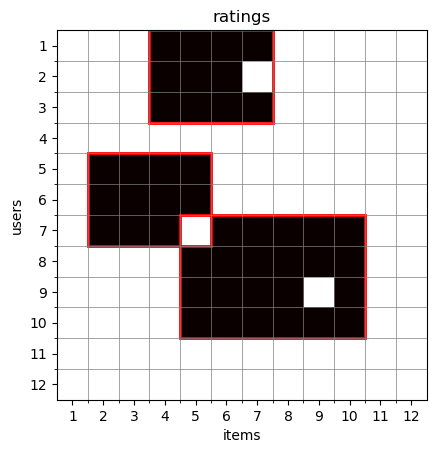

In [3]:
from scipy.sparse import csr_matrix
row = [users.index(user) for (user, item) in ratings]
column = [items.index(item) for (user, item) in ratings]
data = [1] * len(row)
r_c = csr_matrix((data, (row, column)), shape=(len(users), len(items)))

fig, ax, cax = plot_input(-r_c.toarray(), users, items, np.arange(0.5, 11.5, 1))
import matplotlib.patches as mpatches
rect = mpatches.Rectangle([2.5, -0.5], 4, 3, ec="red", fc="none",  ls = '-', lw=2, fill=False, alpha=1.0)
pp = ax.add_patch(rect)
rect = mpatches.Rectangle([0.5, 3.5], 4, 3, ec="red", fc="none",  ls = '-', lw=2, fill=False, alpha=1.0)
pp = ax.add_patch(rect)
rect = mpatches.Rectangle([3.5, 5.5], 6, 4, ec="red", fc="none",  ls = '-', lw=2, fill=False, alpha=1.0)
pp = ax.add_patch(rect)
del pp

We continue with the initial users, items, and ratings that we defined above. For the rest of the analysis, we keep only the active users/items. 

In [4]:
active_users = list(set([user for (user, item) in ratings]))
active_items = list(set([item for (user, item) in ratings]))

items_copy = items[:]
for item in items_copy:
    if item not in active_items:
        items.remove(item)

users_copy = users[:]
for user in users_copy:
    if user not in active_users:
        users.remove(user)

del users_copy, items_copy

row = [users.index(user) for (user, item) in ratings]

column = [items.index(item) for (user, item) in ratings]

data = [1] * len(row)
r_c = csr_matrix((data, (row, column)), shape=(len(users), len(items)))
del row, data, column


## 3. Generative model

We start with the generative model underlying our recommendation approach. 
It formalizes the following intuition: There exist clusters, groups, or communities of users that are interested in a subset of the items.

As users can have several interests, and items might satisfy several needs, each user and item can belong to several co-clusters consisting of users and items. 
However, a co-cluster must contain at least one user and one item, and can therefore not consist of users or items alone. 

Suppose there are $K$ co-clusters ($K$ can be determined from the data, e.g., by cross-validation, as discussed later). 
Affiliation of a user $u$ and item $i$ with a co-cluster is modeled by the $K$-dimensional co-cluster affiliation vectors $\vf_u$ and $\vf_i$,  respectively. 
The entries of $\vf_u, \vf_i$ are constrained to be non-negative, and  $[\vf_u]_c = 0$ signifies that user $u$ does not belong to co-cluster $c$. Here, $[\vf]_c$ denotes the $c$-th entry of $\vf$. 
The absolute value of $[\vf_u]_c$ corresponds to the affiliation strength of $u$ with co-cluster $c$; the larger it is, the stronger the affiliation. 

Positive examples are explained by the co-clusters as follows. If user $u$ and item $i$ both lie in co-cluster $c$, then this co-cluster generates a positive example with probability 

$$
1 - e^{-[\vf_u]_c [\vf_i]_c }. 
$$

Assuming that each co-cluster $c=1,...,K$, generates a positive example independently, it follows that 

$$ 1 - \PR{r_{ui} = 1}  = \prod_c e^{-[\vf_u]_c [\vf_i]_c } = e^{- \innerprod{\vf_u}{\vf_i}}, $$
where $\innerprod{\vf}{\vg} = \sum_c [\vf]_c [\vg]_c$ denotes the inner product in $\reals^K$. Thus 

$$\PR{r_{ui} = 1} = 1 - e^{- \innerprod{\vf_u}{\vf_i}}. $$

A similar generative model also appears in the community detection literature.

## 4. Fitting the model parameters

Given a matrix $\mR$, we fit the model parameters by finding the most likely factors  $\vf_u,\vf_i$ to the matrix $\mR$ by maximizing the likelihood  (recall that we assume positive examples to be generated independently across co-clusters and across items and users in co-clusters):

$$ L = 
\prod_{(u,i)\colon r_{ui}=1}
( 1 - e^{ -\innerprod{\vf_u}{ \vf_i} } )
\prod_{(u,i)\colon r_{ui}=0}
e^{ -\innerprod{\vf_u}{ \vf_i} }. 
$$

Maximizing the likelihood is equivalent to minimizing the negative log-likelihood:

$$
-\log L 
%= - \log \PR{r_{ui} | \mF}
= - \sum_{(u,i)\colon r_{ui} = 1}
\log( 1 - e^{ -\innerprod{\vf_u}{ \vf_i} } )
+ \sum_{(u,i) \colon r_{ui}=0 }  \innerprod{\vf_u}{ \vf_i}.
$$

To prevent overfitting, we add an $\ell_2$ penalty, which results in the following optimization problem:

$$
\text{minimize }Q \text { subject to } [\vf_{u}]_c, [\vf_{i}]_c  \geq 0, \text{ for all } c,
$$

where 

\begin{align}
Q = -\log L + \lambda \sum_i \norm[2]{\vf_i}^2  + \lambda \sum_u \norm[2]{\vf_u}^2 
\end{align}

and $\lambda\geq 0$ is a regularization parameter.


### 4.1 Computing the $L$ and $Q$

Before $L$ and $Q$ are computed, the user and item histories are created from the sparse matrix. Both are dictionaries, with the user history listing all index positions of the items that a user has purchased, while the item history lists all index positions of users that have purchased this specific item.

In [5]:
indexes_of_ones = r_c.nonzero()
indexes_of_ones = set(zip(indexes_of_ones[0], indexes_of_ones[1]))

def input_parser(indexes_of_ones):
    user_c = dict()
    item_c = dict()
    for (user, item) in indexes_of_ones:
        if user not in user_c:
            user_c[user] = [item]
        else: 
            user_c[user].append(item)

        if item not in item_c:
            item_c[item] = [user]
        else: 
            item_c[item].append(user)        
    return user_c, item_c

user_history, item_history = input_parser(indexes_of_ones)
print(user_history, item_history)

{4: [0, 3, 2, 1], 3: [1, 0, 3, 2], 5: [4, 1, 7, 0, 6, 2, 5, 8], 0: [2, 5, 4, 3], 8: [3, 6, 5, 8, 4, 7], 2: [2, 5, 4, 3], 1: [3, 2, 4], 7: [4, 3, 6, 5, 8], 6: [5, 8, 4, 7, 6, 3]} {0: [4, 3, 5], 3: [4, 8, 1, 3, 7, 0, 2, 6], 1: [3, 5, 4], 4: [5, 7, 2, 0, 6, 8, 1], 7: [5, 6, 8], 2: [0, 2, 4, 1, 3, 5], 5: [0, 2, 6, 8, 5, 7], 6: [8, 5, 7, 6], 8: [6, 8, 5, 7]}


In [6]:
# the likehood function
def L(indexes_of_ones, fu, fi):
    import itertools
    product_ones = 1
    product_zeros = 1

    for (u, i) in itertools.product(range(fu.shape[0]), range(fi.shape[0])):
        if (u, i) in indexes_of_ones:
            product_ones *= (1 - np.exp(-np.inner(fu[u], fi[i])))
        else:
            product_zeros *= np.exp(-np.inner(fu[u], fi[i]))
            
    return product_ones * product_zeros

In [7]:
# the Penalized log likehood function
def Q(indexes_of_ones, fu, fi, lam):
    return -np.log(L(indexes_of_ones, fu, fi)) + lam * sum(np.linalg.norm(fu, axis=1)**2) + lam * sum(np.linalg.norm(fi, axis=1)**2)

In [8]:
# the Penalized log likehood function (from the sums)
def Q2(indexes_of_ones, fu, fi, lam):
    import itertools
    sum_ones = 0
    sum_zeros = 0

    for (u, i) in itertools.product(range(fu.shape[0]), range(fi.shape[0])):
        if (u, i) in indexes_of_ones:
            sum_ones += np.log(1 - np.exp(-np.inner(fu[u], fi[i])))
        else:
            sum_zeros += np.inner(fu[u], fi[i])
            
    return - sum_ones + sum_zeros + lam * sum(np.linalg.norm(fu, axis=1)**2) + lam * sum(np.linalg.norm(fi, axis=1)**2)

A common approach to solve an NMF problem is alternating least squares, which iterates between fixing $\vf_u$, and minimizing with respect to $\vf_i$, and fixing $\vf_i$ and minimizing with respect to $\vf_u$, until convergence. 
This strategy is known as cyclic block coordinate descent or the non-linear Gauss-Seidel method. 
Whereas $Q$ is non-convex in  $\vf_i,\vf_u$, $Q$ is convex in  $\vf_i$ (with  $\vf_u$ fixed) and convex in  $\vf_u$ (with $\vf_i$ fixed). 
Therefore, a solution to the subproblems of minimizing $Q$ with fixed $\vf_i$ and minimizing $Q$ with fixed $\vf_u$ can be found, e.g., via gradient descent or Newton's method. 
As this optimization problem is non-convex, one cannot in general guarantee convergence to a global minimum; however, convergence to a stationary point can be ensured. 
Specifically, provided that $\lambda > 0$, $Q$ is strongly convex in  $\vf_i$ (with  $\vf_u$ fixed) and in $\vf_u$ (with $\vf_i$ fixed). 
Thus, the subproblems have unique solutions, and therefore, if we solve each subproblem exactly, convergence to a stationary point is ensured.

However, as noted in the context of matrix factorization, solving the subproblems exactly may slow down convergence. 
Specifically, when $\vf_u,\vf_i$ are far from a stationary point, it is intuitive that there is little reason to allocate computational resources to solve the subproblems exactly. 
It is therefore often more efficient to solve the subproblem only approximately in each iteration. 

For the above reasons, we will only approximately solve each subproblem by using a single step of projected gradient descent with backtracking line search, and iteratively update $\vf_i$ and $\vf_u$ by single projected gradient descent steps until convergence. Convergence is declared if $Q$ stops decreasing. This results in a very efficient algorithm that is essentially linear in the number of positive examples $\{(u,i)\colon r_{ui} = 1\}$, and the number of co-clusters $K$. Our simulations have shown that performing only one gradient descent step significantly speeds up the algorithm. 

## 5. Implementation and complexity

Here we examine in more detail the projected gradient descent approach we use to solve the subproblems and the complexity of the overall optimization algorithm. It is sufficient to discuss minimization of $Q$ with respect to $\vf_i$, as minimization with respect to $\vf_u$ is equivalent. 

We start by noting that, because of  

$$
Q = 
\sum_{i} \left( 
- \sum_{u \colon r_{ui} = 1}
\log( 1 - e^{- \innerprod{\vf_u}{ \vf_i} }  ) 
+ \sum_{u \colon r_{ui} = 0}  \innerprod{\vf_u}{ \vf_i}  \right) + \lambda \sum_{u} \norm[2]{\vf_u}^2 + \lambda \sum_i \norm[2]{\vf_i}^2,
$$

we can minimize $Q$ for each $\vf_i$ individually. The part of $Q$ depending on  $\vf_i$ is given by

$$
Q(\vf_i)
=
- \!\!\!\!\!\sum_{u\colon r_{ui} = 1 }
\log( 1 - e^{- \innerprod{\vf_u}{ \vf_i} }  )
\!+\!  \innerprod{\vf_i }{  \sum_{u \colon r_{ui} = 0 }  \vf_u }  \!+\! \lambda \norm[2]{\vf_i}^2.
$$



In [9]:
# the Penalized log likehood function (from the Qfi)
def Qfi(i, indexes_of_ones, fu, fi, lam):
    import itertools
    sum_ones = 0
    sum_zeros = 0

    for u in range(fu.shape[0]):
        if (u, i) in indexes_of_ones:
            sum_ones += np.log(1 - np.exp(-np.inner(fu[u], fi[i]) - 5e-8))
        else:
            sum_zeros += np.inner(fu[u], fi[i])
            
    return - sum_ones + sum_zeros + lam * np.linalg.norm(fi[i])**2


def Qfu(u, indexes_of_ones, fu, fi, lam):
    import itertools
    sum_ones = 0
    sum_zeros = 0

    for i in range(fi.shape[0]):
        if (u, i) in indexes_of_ones:
            sum_ones += np.log(1 - np.exp(-np.inner(fu[u], fi[i]) - 5e-8))
        else:
            sum_zeros += np.inner(fu[u], fi[i])
            
    return - sum_ones + sum_zeros + lam * np.linalg.norm(fu[u])**2


def Q3(indexes_of_ones, fu, fi, lam):
    q = 0 
    
    for i in range(fi.shape[0]):
        q += Qfi(i, indexes_of_ones, fu, fi, lam)
        
    return q + lam * sum(np.linalg.norm(fu, axis=1)**2)

As mentioned, we update the parameter $\vf_i$ by performing a projected gradient descent step. 
The projected gradient descent algorithm is initialized with a feasible initial factor $\vf_i^{0}$ and updates the current solution $\vf^k_i$ to $\vf^{k+1}_i$ 
according to  

$$
\vf^{k+1}_i = (\vf^{k}_i - \alpha_k   \nabla Q(\vf^k_i) )_+,
$$
where $(\vf)_+$ projects $\vf$ on its positive part, $[(\vf)_+]_c = \max(0, [\vf]_c )$, and the gradient is given by

$$
\nabla Q( \vf_i ) 
= 
-\sum_{u\colon r_{ui} = 1}  \vf_u \frac{e^{- \innerprod{\vf_u}{ \vf_i } }}{1 -e^{-  \innerprod{\vf_u}{ \vf_i} }} 
+ \sum_{u\colon r_{ui} = 0} \vf_u
+ 2 \lambda \vf_i.
$$

As the computation of both $\nabla Q(\vf_i)$ and $Q(\vf_i)$ requires $\sum_{u \colon r_{ui} = 0} \vf_u$, and typically, the number of items for which $r_{ui}=1$ is small relative to the total number of items, we precompute $\sum_u \vf_u $
before updating all $\vf_i$, and then compute $\sum_{u \colon r_{ui} = 0} \vf_u$ via 

$$
\sum_{u \colon r_{ui} = 0} \vf_u = \sum_u \vf_u  - \sum_{u \colon r_{ui} = 1} \vf_u. 
$$

and this results in

$$
\nabla Q( \vf_i ) 
= 
-\sum_{u\colon r_{ui} = 1}  \vf_u \frac{1}{1 -e^{-  \innerprod{\vf_u}{ \vf_i} }} 
+ \sum_{u} \vf_u
+ 2 \lambda \vf_i.
$$

Similarly, 

$$
\nabla Q( \vf_u ) 
= 
-\sum_{i\colon r_{ui} = 1}  \vf_i \frac{1}{1 -e^{-  \innerprod{\vf_u}{ \vf_i} }} 
+ \sum_{i} \vf_i
+ 2 \lambda \vf_u.
$$

and 

$$
\vf^{k+1}_u = (\vf^{k}_u - \alpha_k   \nabla Q(\vf^k_u) )_+,
$$

Using this approach, a gradient descent step of updating $\vf_i$ has cost $O(|\{ u \colon r_{ui}=1\}|   K )$. 
Thus, updating all $\vf_i$ and all $\vf_u$ has cost $O(|\{(i,u)\colon r_{ui}=1\}|  K )$, which means that updating all factors has a cost that is linear in the problem size (i.e., number of positive examples) and linear in the number of co-clusters.

In [10]:
def Qfi_ones(item_i_history, fu, fi_i, sfu, lam):
    sum_ones = 0

    for u in item_i_history:
        inner = np.inner(fu[u], fi_i)
        sum_ones += np.log(1 - np.exp(-inner - 5e-8)) + inner
            
    return - sum_ones + np.inner(fi_i, sfu) + lam * np.linalg.norm(fi_i)**2


def Qfu_ones(user_u_history, fu_u, fi, sfi, lam):
    sum_ones = 0

    for i in user_u_history:
        inner = np.inner(fu_u, fi[i])
        sum_ones += np.log(1 - np.exp(-inner - 5e-8)) + inner
            
    return - sum_ones + np.inner(fu_u, sfi) + lam * np.linalg.norm(fu_u)**2


In [11]:
def DQfi(item_i_history, fu, fi_i, sfu, lam):
    sum_ones = np.zeros(sfu.size) 
    
    for u in item_i_history: 
        sum_ones += (1 / (1 - np.exp(-np.inner(fu[u], fi_i) - 5e-8))) * fu[u]

    return - sum_ones + sfu + 2 * lam * fi_i


def DQfu(user_u_history, fu_u, fi, sfi, lam):
    sum_ones = np.zeros(sfi.size) 
    
    for i in user_u_history:
        sum_ones += (1 / (1 - np.exp(-np.inner(fu_u, fi[i]) - 5e-8)))* fi[i]
                
    return - sum_ones + sfi + 2 * lam * fu_u


def fi_next(ifi_i, item_i_history, fu, sfu, lam, a):
    d = DQfi(item_i_history[ifi_i[0]], fu, ifi_i[1:], sfu, lam)
    return np.maximum(1e-8, ifi_i[1:] - a * d)


def fu_next(ufu_u, user_u_history, fi, sfi, lam, a):
    d = DQfu(user_u_history[ufu_u[0]], ufu_u[1:], fi, sfi, lam)
    return np.maximum(1e-8, ufu_u[1:] - a * d) 

### 5.1 Alternative: vectorized DQfi/DQfu

The vectorized version avoids the for-loop to compute the `DQfi`/`DQfu` and uses a pure numpy solution instead.

In [12]:
def DQfi_v(features, fu, fi_i, sfu, lam):
    return - (fu[features].T * (1 / (1 - np.exp(-np.dot(fu[features], fi_i) - 5e-8)))).sum(axis=1).T + sfu + 2 * lam * fi_i


def DQfu_v(features, fu_u, fi, sfi, lam):
    return - (fi[features].T * (1 / (1 - np.exp(-np.dot(fi[features], fu_u) - 5e-8)))).sum(axis=1).T + sfi + 2 * lam * fu_u 


def fi_next_v(ifi_i, item_i_history, fu, sfu, lam, a):
    d = DQfi_v(item_i_history[ifi_i[0]], fu, ifi_i[1:], sfu, lam)
    return np.maximum(1e-8, ifi_i[1:] - a * d)


def fu_next_v(ufu_u, user_u_history, fi, sfi, lam, a):
    d = DQfu_v(user_u_history[ufu_u[0]], ufu_u[1:], fi, sfi, lam)
    return np.maximum(1e-8, ufu_u[1:] - a * d)

In [13]:
# some cleaning before we start
def delete_vars(variables):
    for var in variables:
        if var in globals():
            del globals()[var]

delete_vars(['active_items', 'active_users', 'item', 'user', 'mpatches', 'rect', 'fig', 'ax'])

### 5.2 Unit tests

To ensure that the functions we created so far are working as expected, we created unit tests to test them.

In [14]:
import unittest
class Tests(unittest.TestCase):
    def __init__(self, *args, **kwargs):
        super(Tests, self).__init__(*args, **kwargs)
        self.lam = 1
        self.k = 3
        self.indexes_of_ones = set([                (0, 2), (0, 3), (0, 4), (0, 5), 
                                                    (1, 2), (1, 3), (1, 4), 
                                                    (2, 2), (2, 3), (2, 4), (2, 5),
                                    (3, 0), (3, 1), (3, 2), (3, 3), 
                                    (4, 0), (4, 1), (4, 2), (4, 3), 
                                    (5, 0), (5, 1), (5, 2),         (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), 
                                                            (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), 
                                                            (7, 3), (7, 4), (7, 5), (7, 6), (7, 8), 
                                                            (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8)])
        self.user_history, self.item_history = input_parser(self.indexes_of_ones)
        self.NU = 9
        self.NI = 9
        self.a = 0.5
        self.fu = np.ones((self.NU, self.k))/2.0
        self.fi = np.ones((self.NI, self.k))/2.0
        self.sfu = np.sum(self.fu, axis=0)
        self.sfi = np.sum(self.fi, axis=0)
        self.expected_L = (1-np.exp(-3/4.0))**44 * np.exp(-3/4.0)**37
        self.expected_Q = -np.log(self.expected_L) + self.lam * (3/4.0) * 9 + self.lam * (3/4.0) * 9
        self.expexted_Qfi_0 = 3*(-np.log((1-np.exp(-3/4.0))) + 7/4.0)
        self.expected_DQfi_0 = 11/2.0 - (3 / (1 - np.exp(-3/4.0)))/2.0
        self.expected_DQfi_3 = 11/2.0 - (8 / (1 - np.exp(-3/4.0)))/2.0
        self.expected_next_fi_0 = max(0, -9/4.0 + (3 / (1 - np.exp(-3/4.0)))/4.0)
        self.expected_next_fi_3 = max(0, -9/4.0 + (8 / (1 - np.exp(-3/4.0)))/4.0)
        self.expected_next_fu_5 = max(0, -9/4.0 + (8 / (1 - np.exp(-3/4.0)))/4.0)
    
    def test_L(self):
        L1 = L(self.indexes_of_ones, self.fu, self.fi)
        self.assertAlmostEqual(L1, self.expected_L, places=5)
    
    def test_Qfi(self):
        Qfi_0 = Qfi(0, self.indexes_of_ones, self.fu, self.fi, self.lam)
        self.assertAlmostEqual(Qfi_0, self.expexted_Qfi_0, places=5)
        
    def test_Qfi_ones(self):
        Qfi_0 = Qfi_ones(self.item_history[0], self.fu, self.fi[0], self.sfu, self.lam)
        self.assertAlmostEqual(Qfi_0, self.expexted_Qfi_0, places=5)    
    
    def test_Q(self):
        Q1 = Q(self.indexes_of_ones, self.fu, self.fi, self.lam)
        self.assertAlmostEqual(Q1, self.expected_Q, places=5)

    def test_Q2(self):      
        Q1_2 = Q2(self.indexes_of_ones, self.fu, self.fi, self.lam)
        self.assertAlmostEqual(Q1_2, self.expected_Q, places=5)
        
    def test_Q3(self):
        Q1_3 = Q3(self.indexes_of_ones, self.fu, self.fi, self.lam)        
        self.assertAlmostEqual(Q1_3, self.expected_Q, places=5)
        
    def test_DQfi_0(self):
        DQfi_0 =  DQfi_v(self.item_history[0], self.fu, self.fi[0], self.sfu, self.lam)
        for i in DQfi_0:
            self.assertAlmostEqual(i, self.expected_DQfi_0, places=5) 
            
    def test_DQfi_3(self):
        DQfi_3 =  DQfi_v(self.item_history[3], self.fu, self.fi[3], self.sfu, self.lam)
        for i in DQfi_3:
            self.assertAlmostEqual(i, self.expected_DQfi_3, places=5)             
            
    def test_next_fi_0(self):
        next_fi_0 = fi_next_v(np.array([0, 0.5, 0.5, 0.5]), self.item_history, self.fu, self.sfu, self.lam, self.a)
        for i in next_fi_0:
            self.assertAlmostEqual(i, self.expected_next_fi_0, places=5)
            
    def test_next_fi_3(self):
        next_fi_3 = fi_next_v(np.array([3, .5, 0.5, 0.5]), self.item_history, self.fu, self.sfu, self.lam, self.a)
        for i in next_fi_3:
            self.assertAlmostEqual(i, self.expected_next_fi_3, places=5)
            
    def test_next_fu_5(self):
        next_fu_5 = fu_next_v(np.array([5, 0.5, 0.5, 0.5]), self.user_history, self.fi, self.sfi, self.lam, self.a)
        for i in next_fu_5:
            self.assertAlmostEqual(i, self.expected_next_fu_5, places=5) 
            
    def test_next_fi_apply_along(self):            
        fi_next_1= np.apply_along_axis(fi_next_v, 1, np.c_[np.arange(self.fi.shape[0]), self.fi], self.item_history, 
                                        self.fu, self.sfu, self.lam, self.a)
        for i in fi_next_1[0,:]:
            self.assertAlmostEqual(i, self.expected_next_fi_0, places=5)
        for i in fi_next_1[3,:]:
            self.assertAlmostEqual(i, self.expected_next_fi_3, places=5)
            
    def test_steps_fi_0(self):
        fi_0 = np.array([0.5, 0.5, 0.5])
        next_fi_0 = fi_next_v(np.array([0, 0.5, 0.5, 0.5]), self.item_history, self.fu, self.sfu, self.lam, self.a)
        DQfi_0 = DQfi_v(self.item_history[0], self.fu, self.fi[0], self.sfu, self.lam)
        Qfi_0 = Qfi(0, self.indexes_of_ones, self.fu, self.fi, self.lam)
        next_Qfi_0 = Qfi(0, self.indexes_of_ones, self.fu,  np.apply_along_axis(fi_next_v, 1, np.c_[np.arange(self.fi.shape[0]), self.fi], self.item_history, self.fu, self.sfu, self.lam, self.a), self.lam)
        
suite = unittest.TestLoader().loadTestsFromTestCase(Tests)
u = unittest.TextTestRunner().run(suite)


.............
----------------------------------------------------------------------
Ran 13 tests in 0.021s

OK


## 6. Ocular fit on the example

The parameters that need to be set for the fit are:
- `k`: number of co-clusters, 
- `max_it`: number of iterations of the for-loop,
- `lam`: regularization parameter,
- `a`: stepsize,
- `fu` and `fi`: need to be initialized with random values,
- `sfi` and `sfu`: sums of the initial `fi` and `fu`.

In [15]:
rnd = np.random.RandomState(seed=123456789)
k = 3
max_it = 20
lam = 0.2
fu = rnd.rand(len(users), k).astype('float64')
fi = rnd.rand(len(items), k).astype('float64')
sfu = np.sum(fu, axis=0)
sfi = np.sum(fi, axis=0)
a = 0.05
iterrate_item = False

for i in range(max_it):
    iterrate_item = not iterrate_item
    if iterrate_item:
        fi = np.apply_along_axis(fi_next_v, 1, np.c_[np.arange(fi.shape[0]), fi], item_history, fu, sfu, lam, a)
        sfi = np.sum(fi, axis=0)
    else:
        fu = np.apply_along_axis(fu_next_v, 1, np.c_[np.arange(fu.shape[0]), fu], user_history, fi, sfi, lam, a)
        sfu = np.sum(fu, axis=0)

The following code block prints out the probabilities for each user/item combination that a user would be interested in it, before plotting the co-clusters that were identified along with the probabilities. In the heatmap, you can see that the area where the co-clusters overlap has a very high probability while in the areas where no co-clusters were identified the values are very low.

[[2.98787766e-01 3.12416566e-01 5.93071752e-01 7.23042441e-01
  6.69384669e-01 5.09250041e-01 3.09335724e-01 2.08401376e-01
  3.80451846e-01]
 [3.35185826e-01 3.54377895e-01 5.85851582e-01 6.84447454e-01
  4.83979322e-01 2.21232276e-01 1.02404957e-01 5.97810503e-02
  1.59914562e-01]
 [3.49253119e-01 3.69008138e-01 6.66148137e-01 7.78950244e-01
  7.01826302e-01 4.92364132e-01 2.53933588e-01 1.53922089e-01
  3.76548294e-01]
 [4.91447508e-01 5.15532835e-01 7.25013256e-01 8.01194777e-01
  4.41716577e-01 3.36185516e-08 2.61791829e-08 2.17389163e-08
  2.55346964e-08]
 [5.27814776e-01 5.52566175e-01 7.61335313e-01 8.33488137e-01
  4.76306201e-01 3.48892483e-08 2.74498796e-08 2.30096130e-08
  2.68053930e-08]
 [4.10397557e-01 4.00916239e-01 7.32047364e-01 8.95303482e-01
  9.24239185e-01 9.01435330e-01 7.93580667e-01 6.69792758e-01
  7.66657153e-01]
 [4.57815638e-02 2.68724476e-08 3.45398863e-01 6.74062264e-01
  8.85106145e-01 8.97233950e-01 7.81480826e-01 6.54066559e-01
  7.62341686e-01]
 [1.72

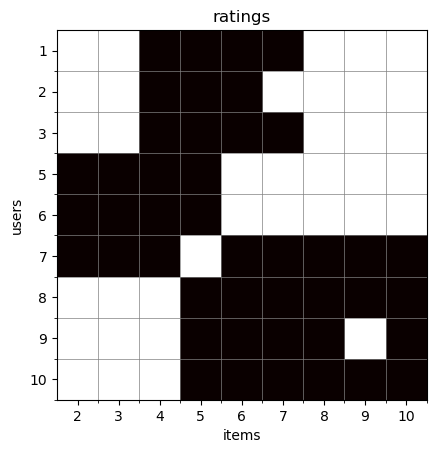

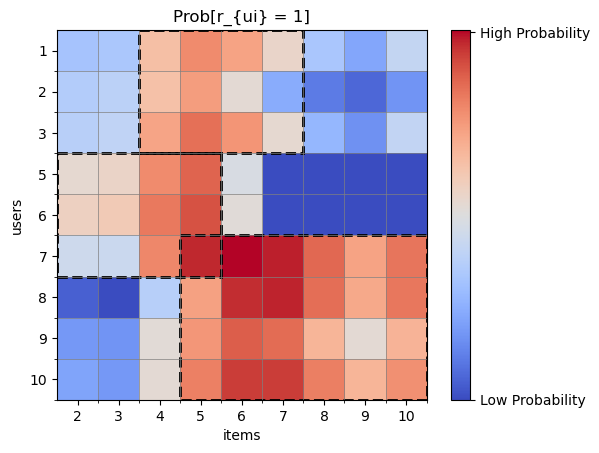

In [16]:
fig, ax, cax = plot_input(-r_c.toarray(), list(set(map(lambda l: users[l[0]], indexes_of_ones))), list(set(map(lambda l: items[l[1]], indexes_of_ones))), np.arange(0.5, 9.5, 1))
fig, ax, cax = plot_input(1 - np.exp(-np.dot(fu, fi.T)), list(set(map(lambda l: users[l[0]], indexes_of_ones))), list(set(map(lambda l: items[l[1]], indexes_of_ones))), np.arange(0.5, 9.5, 1), 
                          cmap='coolwarm', title='Prob[r_{ui} = 1]')
cbar = fig.colorbar(cax, ticks=[0.0001, 0.92])
cbar.ax.set_yticklabels(['Low Probability', 'High Probability'])
print(1 - np.exp(-np.dot(fu, fi.T)))

import matplotlib.patches as mpatches
rect = mpatches.Rectangle([1.5, -0.5], 4, 3, ec="black", fc="none",  ls = '--', lw=2, fill=False, alpha=1.0)
pp = ax.add_patch(rect)
rect = mpatches.Rectangle([-0.5, 2.5], 4, 3, ec="black", fc="none",  ls = '--', lw=2, fill=False, alpha=1.0)
pp = ax.add_patch(rect)
rect = mpatches.Rectangle([2.5, 4.5], 6, 4, ec="black", fc="none",  ls = '--', lw=2, fill=False, alpha=1.0)
pp = ax.add_patch(rect)
del pp

Let's clean up by deleting some of the variables that are not needed anymore, before continuing with the second part of the notebook.

In [17]:
delete_vars(['it', 'iterrate_item', 'suite', 'u', 'rect', 'pp', 'fig', 'ax', 'cax', 'mpatches', 'cbar'])
%whos

Variable          Type           Data/Info
------------------------------------------
DQfi              function       <function DQfi at 0x7ff6797389d0>
DQfi_v            function       <function DQfi_v at 0x7ff679738dc0>
DQfu              function       <function DQfu at 0x7ff679738a60>
DQfu_v            function       <function DQfu_v at 0x7ff679738e50>
L                 function       <function L at 0x7ff6796ff2e0>
Q                 function       <function Q at 0x7ff6796ff640>
Q2                function       <function Q2 at 0x7ff6796ffa30>
Q3                function       <function Q3 at 0x7ff6796ffe20>
Qfi               function       <function Qfi at 0x7ff6796ffd00>
Qfi_ones          function       <function Qfi_ones at 0x7ff6797384c0>
Qfu               function       <function Qfu at 0x7ff6796ffd90>
Qfu_ones          function       <function Qfu_ones at 0x7ff679738550>
Tests             type           <class '__main__.Tests'>
a                 float          0.05
csr_matrix    

## Part B: Ocular with MovieLens

Let's apply this to a real-world data set. The <a href= "https://movielens.org" target="_blank" rel="noopener noreferrer">MovieLens</a> project is run by <a href= "http://grouplens.org/" target="_blank" rel="noopener noreferrer">GroupLens</a> at the University of Minnesota and offers non-commercial, personalized movie recommendations. They also released several data sets to support people developing recommender algorithms. 

In this notebook, you will work with the small dataset of 100,000 ratings of 9,000 movies that were provided by 700 users.

## 1. Load the MovieLens data
### 1.1 Download the data

To download the data:

1. Download `ml-latest-small.zip` from <a href="https://grouplens.org/datasets/movielens/latest/" target="_blank" rel="noopener noreferrer">MovieLens Latest DataSets</a>.
1. Unzip the folder. The file you'll be using is `ratings.csv`.

### 1.2 Load the data-file to the notebook

To load the ratings.csv file into a Spark DataFrame:

1. Click the **Find and Add Data** button on the notebook action bar (the 1001 button - second from the right in the navigation bar). Drag and drop the file into the box or click `browse` to select the file from your directory. The file is loaded to your object storage.
1. To load the data into your notebook, make sure you have the following code cell selected.
1. Click the Code snippets icon and then click **Read data**->**Select data from project**.
1. Locate the `ratings.csv` **Data asset** in your project.
1. From the Read data pane, load the asset as a Pandas DataFrame. The code to create a Pandas DataFrame will be automatically inserted to the selected code cell. The code contains credentials, so the cell will be hidden when you're sharing the notebook.
1. Change the name of the DataFrame to `ratings` in the last two lines.

In [18]:
# Insert code here



,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## 2. Prepare the data

In this part, you will learn how to prepare the data so that it can be fed to the `OCuLaR` algorithm.

### 2.1 Select positive ratings

`OCuLaR` was developed to get recommendations from data that only provides information on what items a user is interested in, e.g. a purchase history. To imitate the original input data, we will only select positive ratings with a score of 3 or above and treat them equally to a purchased item by a user. Negative ratings will be treated equally to movies that have not been rated by the user.

In [19]:
positive_ratings_frame = ratings[ratings['rating'] >= 3]
positive_ratings_frame.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### 2.2 Remove "bad" users and items

In this case, "bad" refers to users who only did one rating and movies that only received one rating.

In [20]:
# removing bad users
positive_ratings_frame = positive_ratings_frame.groupby('userId').filter(lambda x: len(x) > 1)

# removing bad items
positive_ratings_frame = positive_ratings_frame.groupby('movieId').filter(lambda x: len(x) > 1)

### 2.3 Split data

We split the data using the `train_test_split` in the `sklearn` package. If you use a newer version of `sklearn` than 0.17, you will need to import the function from `sklearn.model_selection`. 

In [21]:
from sklearn.model_selection import train_test_split

train_data_frame,test_data_frame = train_test_split(positive_ratings_frame, test_size=0.2, random_state=123456789)

The remaining data preparation part is similar to the preparation that you have already seen in part A. At first, only the active users/items are selected, before creating two dictionaries containing the history of each user respectively each item.

### 2.4 Get list of active users/items

In [22]:
ratings_train = train_data_frame.values.tolist()
ratings_test = test_data_frame.values.tolist()

active_users = sorted(list(set(map(lambda x: x[0], ratings_train))))
active_items = sorted(list(set(map(lambda x: x[1], ratings_train))))
active_users_test = sorted(list(set(map(lambda x: x[0], ratings_test))))
active_items_test = sorted(list(set(map(lambda x: x[1], ratings_test))))

### 2.5 Get user/item history

In [23]:
users_d = dict(zip(active_users, range(len(active_users))))
items_d = dict(zip(active_items, range(len(active_items))))

row = []
column = []

for r in ratings_train:
    row.append(users_d[r[0]])
    column.append(items_d[r[1]])
    
data = [1] * len(row)
r_c = csr_matrix((data, (row, column)), shape=(len(active_users), len(active_items)))
del row, column

indexes_of_ones = r_c.nonzero()
indexes_of_ones = set(zip(indexes_of_ones[0], indexes_of_ones[1]))

user_history, item_history = input_parser(indexes_of_ones)

We repeat this process for the test set, as we will need the user/item histories to compute the recall later.

In [24]:
users_d_test = dict(zip(active_users_test, range(len(active_users_test))))
items_d_test = dict(zip(active_items_test, range(len(active_items_test))))

row = []
column = []

for r in ratings_test:
    row.append(users_d_test[r[0]])
    column.append(items_d_test[r[1]])
    
data = [1] * len(row)    
r_c_test = csr_matrix((data, (row, column)), shape=(len(active_users_test), len(active_items_test)))
del row, column

indexes_of_ones_test = r_c_test.nonzero()
indexes_of_ones_test = set(zip(indexes_of_ones_test[0], indexes_of_ones_test[1]))

user_history_test, item_history_test = input_parser(indexes_of_ones_test)

## 3. The selection of the step size
The step size $\alpha_k$ is selected using a backtracking line search, also referred to as the Armijo rule along the projection arc. 
Specifically, $\alpha_k = \beta^{t_k}$, where $t_k$ is the smallest positive integer such that 

$$
Q(\vf^{k+1}_i) - Q(\vf^k_i)
\leq
\sigma \innerprod{\nabla Q(\vf^k_i)}{ \vf^{k+1}_i  - \vf^k_i }
$$

where $\sigma,\beta \in (0,1)$ are user-set constants. 

In addition to the parameters already used in part A, we need `sigma` and `lsParam` for the line search. `M_rec` is the maximum number of items that will be recommended to a user. This variable becomes relevant when computing the recall in the next step.

In [25]:
# initialize the parameters and the fs
rnd = np.random.RandomState(seed=123456789)
k = 1000
lam = 600
max_it = 20
fu = rnd.rand(len(active_users), k)
fi = rnd.rand(len(active_items), k)
sfu = np.sum(fu, axis=0)
sfi = np.sum(fi, axis=0)
sigma = 0.01
lsParam = 5e-3
M_rec = 130

The affiliation strength is computed individually for each user and item inside the while loop that iterates until the right step size has been found. In the last line, the probabilities are computed from the results.

In [26]:
for it in range(max_it):
    # items
    for i in range(fi.shape[0]):
        a = 1
        active = True
        d = DQfi_v(item_history[i], fu, fi[i], sfu, lam)
        old_cost = Qfi_ones(item_history[i], fu, fi[i], sfu, lam)
        old_fi = fi[i,:].copy()
        
        while active:     
            fi_new = fi_next_v(np.append([i], old_fi), item_history, fu, sfu, lam, a)
            fi[i,:] = fi_new
            RHS = sigma * np.inner(d, (fi_new - old_fi))
            new_cost = Qfi_ones(item_history[i], fu, fi[i], sfu, lam)
            active = new_cost - old_cost > RHS + lsParam
            a *= 0.1
            
    sfi = np.sum(fi, axis=0)

    # users
    for u in range(fu.shape[0]):
        a = 1
        active = True
        d = DQfu_v(user_history[u], fu[u], fi, sfi, lam)
        old_cost = Qfu_ones(user_history[u], fu[u], fi, sfi, lam)
        old_fu = fu[u,:].copy()   
        
        while active:
            fu_new = fu_next_v(np.append([u], old_fu), user_history, fi, sfi, lam, a)
            fu[u,:] = fu_new
            RHS = sigma * np.inner(d, (fu_new - old_fu))
            new_cost = Qfu_ones(user_history[u], fu[u], fi, sfi, lam)
            active = new_cost - old_cost > RHS + lsParam
            a *= 0.1
 
    sfu = np.sum(fu, axis=0)

# Computes the probabilities
prob = 1 - np.exp(-np.dot(fu, fi.T))

## 4. Recall

To evaluate the performance of Ocular, we compute the recall at M with M being the number of recommended items. As `OCuLaR` was developed for a one-class setting, we treat negative ratings equally to movies without ratings. That means we do not know that a user is not interested in a movie just because he did not rate it. For these cases recall is the more suitable method to evaluate the recommendations than precision.

In [27]:
recall = dict()

# get common users
for u in users_d_test:
    if u in users_d:
        test_user_index = users_d_test[u]
        train_user_index = users_d[u]

        # movies rated by user
        rated_movie_ind = user_history_test[test_user_index]
        rated_movie_IDs = [list(items_d_test.keys())[list(items_d_test.values()).index(i)] for i in rated_movie_ind]
        all_positives = len(rated_movie_ind)

        # recommendations for user
        top_recs_ind = np.argsort(-prob)[train_user_index, :]

        for m in range(10, M_rec + 10, 10):
            exclude_zeros = min(m, sum(prob[train_user_index, :] > 0))
            rec_ind = top_recs_ind[:exclude_zeros]
            rec_movie_IDs = [list(items_d.keys())[list(items_d.values()).index(i)] for i in rec_ind]

            # movies that were recommended and rated
            true_pos = len([rmi for rmi in rec_movie_IDs if rmi in rated_movie_IDs])
            
            # recall for user
            recall_user = float(true_pos)/float(all_positives)
            
            # append to dict to get recall for each M
            if m not in recall:
                recall[m] = [recall_user]
            else:
                recall[m] = recall[m] + [recall_user]

To get an overview of the results, we plot the recall in a boxplot using Matplotlib.

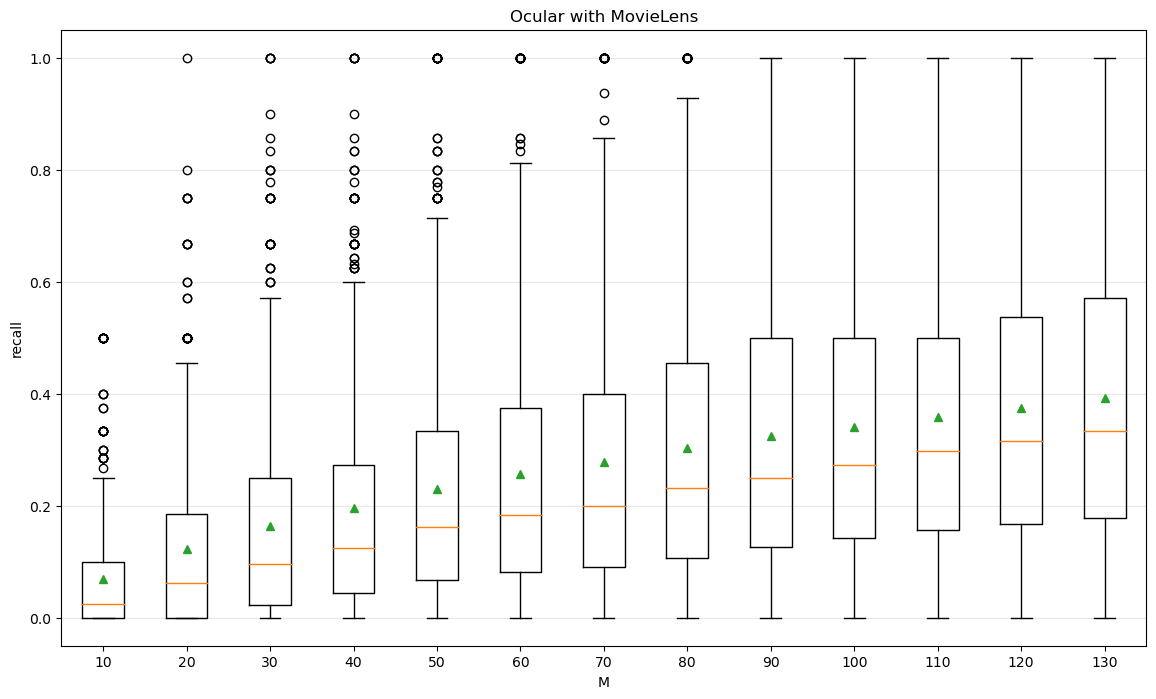

In [28]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

labels = sorted(recall.keys())
data = [recall[m] for m in labels]

fig, ax1 = plt.subplots(figsize=(14, 8))
plt.boxplot(data, showmeans=True)
ax1.set_xticklabels(labels)
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Ocular with MovieLens')
ax1.set_xlabel('M')
ax1.set_ylabel('recall')

plt.show()

## 5. Summary

In this notebook, you learned how the `OCuLaR` algorithm works and how you can implement it. The second part showed you how to prepare your data so you can use the `OCuLaR` algorithms to create recommendations and evaluate its performance using recall. You can now apply this to your own data sets and get recommendations with the `OCuLaR` algorithm.

### Authors

**Vasileios Vasileiadis** is with the Cognitive Systems group at IBM Research - Zurich. He received his Ph.D. degree from Democritus University of Thrace, Greece. His research interests focus on statistical signal processing, data mining, and recommender systems.

**Michail Vlachos** is a Research Staff Member in the Cognitive Systems group at the IBM Research - Zurich. He received his Ph.D. from University of California, Riverside, and his M.B.A. from University of Illinois at Urbana-Champaign. He has been the principal investigator of the ERC Grant on "Exact Mining from InExact Data". His research interests are in the areas of data mining, machine learning, and information retrieval.

**Thomas Parnell** received his Ph.D. in mathematics from the University of Warwick. U.K. In 2007, he co-founded Siglead Europe, where he was involved in developing signal processing and coding algorithms for HDD and flash storage technologies. In 2013, he joined IBM Research - Zurich, where he is involved in developing advanced controller technology for the next-generation of IBM FlashSystem products. His research interests include signal processing, information theory, and machine learning.

**Celestine Dünner** is a predoctoral researcher in the Analytics Infrastructure group at IBM Research - Zurich, and a Ph.D. candidate in Computer Science at the Swiss Federal Institute of Technology (ETH), where she is a member of the ETH data analytics laboratory led by professor Thomas Hofmann. Her current research interests focus on improving the interface between system and algorithm design for scalable and efficient machine learning applications.

**Kathrin Wardatzky** is doing a master's degree with a focus on Information Science at the Hamburg University of Applied Sciences (HAW Hamburg), Germany. During her internship in the Cognitive Systems group at IBM Research - Zurich, she worked on porting the Ocular algorithm to the Watson Studio environment.

### Data Citation

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=<a href="http://dx.doi.org/10.1145/2827872" target="_blank" rel="noopener noreferrer">10.1145/2827872</a>


<hr>
Copyright &copy; IBM Corp. 2017, 2018. This notebook and its source code are released under the terms of the MIT License.